# Create natural emissions to run FaIR with

Theme Song: House of Jealous Lovers<br>
Artist: The Rapture<br>
Album: Echoes<br>
Released: 2003

In [1]:
import numpy as np
import os

from scipy.optimize import root
from scipy.interpolate import interp1d
from fair.constants.general import M_ATMOS
from fair.constants import molwt
from fair.forward import fair_scm

import fair
import pandas as pd
import matplotlib.pyplot as pl

In [2]:
# calculate natural methane emissions
def lifetime(tau, c1, c0):
    delta_tau = 0.32 * (np.log(c1) - np.log(c0))
    return np.exp(np.log(tau) + delta_tau)

def func_ch4(nat, e1, e0, c1, c0, tau):
    z = M_ATMOS/1e18 * molwt.CH4/molwt.AIR
    return 2*z*(c1-c0*(1-(1-np.exp(-1/tau))) - 1/(2*z) * (e0+nat+e1))-nat

def func_n2o(nat, e1, e0, c1, c0, tau):
    z = M_ATMOS/1e18 * molwt.N2/molwt.AIR #/ (molwt.N2O/molwt.N2)
    return 2*z*(c1-c0*(1-(1-np.exp(-1/tau))) - 1/(2*z) * (e0+nat+e1))-nat


ssp_df = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
n2oconc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|N2O')),'1750':'2500'].values.squeeze()
ch4conc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|CH4')),'1750':'2500'].values.squeeze()

cf4conc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|CF4')),'1750':'2500'].values.squeeze()
halon1211conc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|Halon1211')),'1750':'2500'].values.squeeze()
ch3brconc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|CH3Br')),'1750':'2500'].values.squeeze()
ch3clconc = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']=='ssp245')&(ssp_df['Variable'].str.endswith('|CH3Cl')),'1750':'2500'].values.squeeze()

ssp_df = pd.read_csv('../data_input_large/rcmip-emissions-annual-means-v5-1-0.csv')
sspn2oemis = np.zeros(751)
sspch4emis = np.zeros(751)
sspcf4emis = np.zeros(751)
ssphalon1211emis = np.zeros(751)
sspch3bremis = np.zeros(751)
sspch3clemis = np.zeros(751)

years_future = [2015] + list(range(2020,2501,10))
sspch4emis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH4')),'1750':'2014']
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH4')),'2015':'2500'].dropna(axis=1))
sspch4emis[265:] = f(np.arange(2015, 2501))
sspn2oemis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|N2O')),'1750':'2014']*molwt.N2/molwt.N2O/1000
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|N2O')),'2015':'2500'].dropna(axis=1))
sspn2oemis[265:] = f(np.arange(2015, 2501))*molwt.N2/molwt.N2O/1000
sspcf4emis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CF4')),'1750':'2014']
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CF4')),'2015':'2500'].dropna(axis=1))
sspcf4emis[265:] = f(np.arange(2015, 2501))
ssphalon1211emis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|Halon1211')),'1750':'2014']
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|Halon1211')),'2015':'2500'].dropna(axis=1))
ssphalon1211emis[265:] = f(np.arange(2015, 2501))
sspch3bremis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH3Br')),'1750':'2014']
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH3Br')),'2015':'2500'].dropna(axis=1))
sspch3bremis[265:] = f(np.arange(2015, 2501))
sspch3clemis[:265] = ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH3Cl')),'1750':'2014']
f = interp1d(years_future, ssp_df.loc[(ssp_df['Scenario']=='ssp245')&(ssp_df['Region']=='World')&(ssp_df['Variable'].str.endswith('|CH3Cl')),'2015':'2500'].dropna(axis=1))
sspch3clemis[265:] = f(np.arange(2015, 2501))

# any updates to these? chapter 6?
tau_ch4 = 9.3
tau_n2o = 121.0
tau_cf4 = 50000
tau_halon1211 = 16
tau_ch3br = 0.8
tau_ch3cl = 1

solch4 = root(func_ch4, 150, args=(sspch4emis[0], sspch4emis[0], ch4conc[0], ch4conc[0], tau_ch4))
soln2o = root(func_n2o, 8, args=(sspn2oemis[0], sspn2oemis[0], n2oconc[0], n2oconc[0], tau_n2o))
#solcf4
#solhalon1211
#solch3br
#solch3cl

ch4emis = np.zeros(751)
n2oemis  = np.zeros(751)
ch4emis[0] = solch4.x
n2oemis[0]  = soln2o.x

for i in range(1,736):
    solch4 = root(func_ch4, ch4emis[i-1], args=(sspch4emis[i], sspch4emis[i-1], ch4conc[i], ch4conc[i-1], tau_ch4))
    ch4emis[i] = solch4.x
    soln2o = root(func_n2o, n2oemis[i-1], args=(sspn2oemis[i], sspn2oemis[i-1], n2oconc[i], n2oconc[i-1], tau_n2o))
    n2oemis[i] = soln2o.x
#    print sol.x

ch4emis[265:] = ch4emis[264]
n2oemis[265:] = n2oemis[264]
#np.savetxt('natural_fixed.txt', np.vstack([np.arange(1765,2501), ch4emis1, n2oemis]).T, fmt='%9.4f')

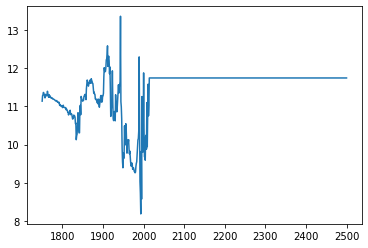

In [3]:
fig, ax1 = pl.subplots()
ax1.plot(np.arange(1750,2501), n2oemis)

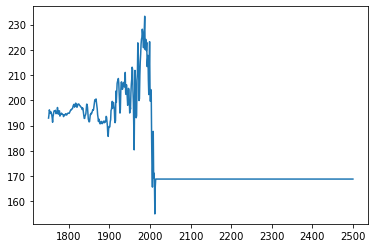

In [4]:
fig, ax1 = pl.subplots()
ax1.plot(np.arange(1750,2501), ch4emis)

In [5]:
df = pd.DataFrame({'year':np.arange(1750,2501),
                   'CH4': ch4emis,
                   'N2O': n2oemis})
df.set_index('year', inplace=True)
df
df.to_csv('../data_output/fair_wg3_natural_ch4_n2o.csv')

In [6]:
def emis_to_conc(c0, e0, ts, lt, vm):
    """Calculate concentrations of well mixed GHGs from emissions for simple
    one-box model.
    
    Inputs (all can be scalar or 1D arrays for multiple species):
        c0: concentrations in timestep t-1
        e0: emissions in timestep t-1
        e1: emissions in timestep t
        ts: length of timestep. Use 1 for sensible results in FaIR 1.3.
        lt: atmospheric (e-folding) lifetime of GHG
        vm: conversion from emissions units (e.g. Mt) to concentrations units
            (e.g. ppb)
            
    Outputs:
        c1: concentrations in timestep t
    """
    c1 = c0 - c0 * (1.0 - np.exp(-ts/lt)) + ts * e0 * vm
    return c1 - c0

c1 = cf4conc[0]

solcf4 = root(emis_to_conc, cf4conc[0], args=(sspcf4emis[0], 1, tau_cf4, 1/(M_ATMOS/1e18*molwt.CF4/molwt.AIR)))
solhalon1211 = root(emis_to_conc, halon1211conc[0], args=(ssphalon1211emis[0], 1, tau_halon1211, 1/(M_ATMOS/1e18*molwt.HALON1211/molwt.AIR)))
solch3br = root(emis_to_conc, ch3brconc[0], args=(sspch3bremis[0], 1, tau_ch3br, 1/(M_ATMOS/1e18*molwt.CH3BR/molwt.AIR)))
solch3cl = root(emis_to_conc, ch3clconc[0], args=(sspch3clemis[0], 1, tau_ch3cl, 1/(M_ATMOS/1e18*molwt.CH3CL/molwt.AIR)))

print(solcf4.x)
print(solhalon1211.x)
print(solch3br.x)
print(solch3cl.x)

[32.28077001]
[0.00434894]
[8.75191031]
[755.7838942]
